# Setup

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import math
import operator
import multiprocessing
import numpy as np
import pandas as pd
from scipy import interp
from patsy import dmatrices
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [75]:
train = pd.read_csv("data/train.csv")
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

def date_feat(month, day):
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

def pdays_feat(day):
    return -1 if day == -1 else day % 7

def transform(X):
    X['dayofyear_'] = np.vectorize(date_feat)(X['month'], X['day'])
    X['dayofweek']  = X['dayofyear_'] % 7
    X['pdayofweek'] = np.vectorize(pdays_feat)(X['pdays'])
    X = X.drop("dayofyear_", axis=1)
    X = X.drop("day", axis=1)
    X = X.drop("pdays", axis=1)
    return X

train_num = transform(train.copy())
train_num.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,previous,poutcome,y,dayofweek,pdayofweek
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,apr,939,1,0,unknown,1,2,-1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,feb,172,10,0,unknown,1,0,-1
2,3,36,management,single,tertiary,no,436,no,no,cellular,apr,567,1,2,failure,1,5,0
3,4,63,retired,married,secondary,no,474,no,no,cellular,jan,423,1,0,unknown,1,4,-1
4,5,31,management,single,tertiary,no,354,no,no,cellular,apr,502,1,2,success,1,1,2


In [78]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          27128 non-null  int64 
 1   age         27128 non-null  int64 
 2   job         27128 non-null  object
 3   marital     27128 non-null  object
 4   education   27128 non-null  object
 5   default     27128 non-null  object
 6   balance     27128 non-null  int64 
 7   housing     27128 non-null  object
 8   loan        27128 non-null  object
 9   contact     27128 non-null  object
 10  month       27128 non-null  object
 11  duration    27128 non-null  int64 
 12  campaign    27128 non-null  int64 
 13  previous    27128 non-null  int64 
 14  poutcome    27128 non-null  object
 15  y           27128 non-null  int64 
 16  dayofweek   27128 non-null  int64 
 17  pdayofweek  27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [79]:
y, X = dmatrices(
    "y ~ age + job + marital + education + default + balance + housing + loan + contact + month + duration + campaign + previous + poutcome + dayofweek + pdayofweek",
    data=train_num,
    return_type='dataframe')
X.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,poutcome[T.other],poutcome[T.success],poutcome[T.unknown],age,balance,duration,campaign,previous,dayofweek,pdayofweek
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,39.0,1756.0,939.0,1.0,0.0,2.0,-1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,51.0,1443.0,172.0,10.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,36.0,436.0,567.0,1.0,2.0,5.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,63.0,474.0,423.0,1.0,0.0,4.0,-1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,31.0,354.0,502.0,1.0,2.0,1.0,2.0


In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27128 entries, 0 to 27127
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Intercept               27128 non-null  float64
 1   job[T.blue-collar]      27128 non-null  float64
 2   job[T.entrepreneur]     27128 non-null  float64
 3   job[T.housemaid]        27128 non-null  float64
 4   job[T.management]       27128 non-null  float64
 5   job[T.retired]          27128 non-null  float64
 6   job[T.self-employed]    27128 non-null  float64
 7   job[T.services]         27128 non-null  float64
 8   job[T.student]          27128 non-null  float64
 9   job[T.technician]       27128 non-null  float64
 10  job[T.unemployed]       27128 non-null  float64
 11  job[T.unknown]          27128 non-null  float64
 12  marital[T.married]      27128 non-null  float64
 13  marital[T.single]       27128 non-null  float64
 14  education[T.secondary]  27128 non-null

# Compare AUCs

In [81]:
train_df, valid_df = train_test_split(train)
train_df = transform(train_df.copy())
valid_df = transform(valid_df.copy())

In [82]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,previous,poutcome,y,dayofweek,pdayofweek
25234,25235,39,management,married,tertiary,no,4539,no,no,cellular,apr,301,1,0,unknown,0,1,-1
24245,24246,44,management,married,tertiary,no,3665,no,no,cellular,mar,325,1,0,unknown,0,6,-1
19760,19761,34,admin.,single,secondary,yes,7,no,no,unknown,may,285,2,0,unknown,0,1,-1
15417,15418,73,retired,married,tertiary,no,459,no,no,cellular,feb,281,1,0,unknown,1,6,-1
14195,14196,35,technician,married,secondary,no,2201,no,no,telephone,apr,350,1,0,unknown,1,4,-1


In [83]:
valid_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,previous,poutcome,y,dayofweek,pdayofweek
24312,24313,40,admin.,single,tertiary,no,1248,no,no,unknown,jun,1290,2,0,unknown,1,1,-1
11127,11128,34,management,single,tertiary,no,757,no,no,cellular,aug,37,4,0,unknown,0,6,-1
6028,6029,39,technician,divorced,tertiary,no,113,yes,yes,cellular,apr,1012,2,0,unknown,0,1,-1
18001,18002,42,blue-collar,married,primary,no,692,no,yes,unknown,jun,207,1,0,unknown,0,2,-1
5618,5619,35,blue-collar,single,primary,no,398,yes,no,unknown,may,34,1,0,unknown,0,2,-1


In [84]:
def evaluate(formula, classifiers):
    y, X = dmatrices(formula, data=train_df, return_type='dataframe')
    X_train = X.values
    y_train = y.y.values

    y, X = dmatrices(formula, data=valid_df, return_type='dataframe')
    X_valid = X.values
    y_valid = y.y.values
    
    for classifier in classifiers:
        print(type(classifier).__name__.ljust(50), end="\t")
        classifier.fit(X_train, y_train)

        probas_train = classifier.predict_proba(X_train)[:, 1]
        print("train: {0:.5f}".format(roc_auc_score(y_train, probas_train)), end="\t")

        probas_valid = classifier.predict_proba(X_valid)[:, 1]
        print("valid: {0:.5f}".format(roc_auc_score(y_valid, probas_valid)))

In [85]:
ada = AdaBoostClassifier(
    n_estimators=500)
gbdt = GradientBoostingClassifier(
    n_estimators=500)
rf = RandomForestClassifier(
    n_estimators=2000,
    n_jobs=multiprocessing.cpu_count())

models = [ada, gbdt, rf]

features = ['age', 'balance', 'duration', 'campaign', 'pdayofweek', 'previous', 'dayofweek']

In [86]:
for feature in features:
    print(feature)
    evaluate('y ~ {}'.format(feature), models)
    print('')

age
AdaBoostClassifier                                	train: 0.60964	valid: 0.58284
GradientBoostingClassifier                        	train: 0.60999	valid: 0.58206
RandomForestClassifier                            	train: 0.60992	valid: 0.58148

balance
AdaBoostClassifier                                	train: 0.62692	valid: 0.58550
GradientBoostingClassifier                        	train: 0.72409	valid: 0.58968
RandomForestClassifier                            	train: 0.87617	valid: 0.56983

duration
AdaBoostClassifier                                	train: 0.81478	valid: 0.80579
GradientBoostingClassifier                        	train: 0.82576	valid: 0.80246
RandomForestClassifier                            	train: 0.84864	valid: 0.75100

campaign
AdaBoostClassifier                                	train: 0.57575	valid: 0.57875
GradientBoostingClassifier                        	train: 0.57575	valid: 0.57857
RandomForestClassifier                            	train: 0.57575	valid: 0.5

In [100]:
def feature_importances_(xbg, columns):
#    b = xbg.booster()
#    print(b)
    fscore = xbg.get_booster().get_fscore()
    importance = sorted(fscore.items(), key=operator.itemgetter(1))
    importance = list(map(lambda a: [columns[int(a[0][1:])], a[1]], importance))
        
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    return df

In [98]:
def xgb_feature_importances(formula, xgb):
    y, X = dmatrices(formula, data=train_df, return_type='dataframe')
    X_train = X.values
    y_train = y.y.values

    y, X = dmatrices(formula, data=valid_df, return_type='dataframe')
    X_valid = X.values
    y_valid = y.y.values
    
    xgb.fit(X_train, y_train)
    
    probas_train = xgb.predict_proba(X_train)[:, 1]
    print("train: {0:.5f}".format(roc_auc_score(y_train, probas_train)), end="\t")

    probas_valid = xgb.predict_proba(X_valid)[:, 1]
    print("valid: {0:.5f}".format(roc_auc_score(y_valid, probas_valid)))
    
    feature_importances = feature_importances_(xgb, X.columns)

    plt.figure()
    feature_importances.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')

train: 0.96307	valid: 0.91707


<Figure size 432x288 with 0 Axes>

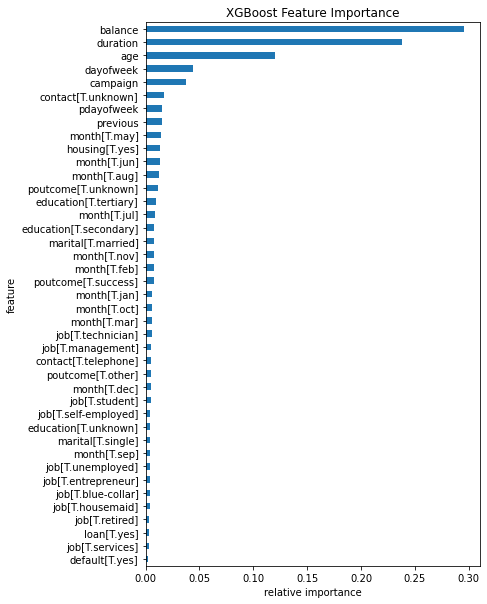

In [101]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=500,
    max_depth=3,
    gamma=0,
    min_child_weight=10)
xgb_feature_importances(
    'y ~ age + job + marital + education + default + balance + housing + loan + contact + month + dayofweek + duration + campaign + pdayofweek + previous + poutcome',
    xgb)